In [7]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..")
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [8]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 1

# Set Perturbation Values 
pos_error = 5000 # Position knowledge error [m]
vel_error = 5    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep);

┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


  6.079166 seconds (56.91 M allocations: 2.397 GiB, 11.24% gc time)


In [47]:
# Compute True and perturbed collects

# Load test images
@time images = load_images("../data/landsat_test.json", dwell_time=10.0);

@time true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);
@time collects = compute_collects_by_number(true_opportunities, 1);

  0.001332 seconds (5.90 k allocations: 354.953 KiB)
 25.526899 seconds (336.98 M allocations: 35.563 GiB, 17.68% gc time)
  0.001487 seconds (5.64 k allocations: 325.641 KiB)


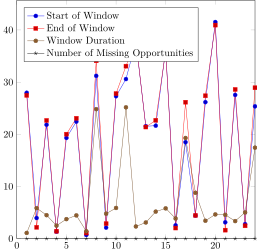

In [48]:
# Plot Differences in Opportunities
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_opportunities, legendentry="Number of Missing Opportunities")
], width="10cm", height="10cm", legendPos="north west", xmin=0, xmax=24, ymin=0)

In [49]:
# Graph planning
path, reward, image_list = sp_graph_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward, Number of Images: $(length(image_list))")

Total planning reward: 39.0, Number of Images: 39


In [54]:
Pkg.add("JuMP")
Pkg.add("Gurobi")

using JuMP
using Gurobi

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [55]:
# Mixed-Integer Programming Planning

mcollects = deepcopy(collects)

# Initialize MILP problem
milp = Model(solver=GurobiSolver(Cuts=0, Presolve=0, Heuristics=0.0))

# Sort Collects to ensure they are in time-asecnding order
sort!(mcollects, by = x -> x.sow)

# constraint_list = Function[constraint_agility_single_axis]
constraint_list = Function[constraint_agility_single_axis]

horizon = 0
allow_repeats = false

# Initialize Variables
@variable(milp, x[1:length(mcollects)], Bin)

# Add Objective
@objective(milp, Max, sum(col.image.reward*x[i] for (i,col) in enumerate(mcollects)))

# Define non-repetition constraints if necessary
if allow_repeats == false
    # Group collects by image
    image_collects = group_image_collects(mcollects) # Group collects by image
    
    # Add constraints to limit one collect per image
    for img in keys(image_collects)
        # Only add constraints for when there is more than one possible collect
        if length(image_collects[img]) >= 1
            @constraint(milp, sum(x[i] for i in collect(e[1] for e in image_collects[img])) <= 1)
        end
    end
end

# Add satellite model-derived constraints
for (i, col_start) in enumerate(mcollects)
    for (j, col_end) in enumerate(mcollects)
        if horizon > 0 && col_end.sow > (col_start.eow + horizon)
            # Condition to exit early is only considering transitions within a certain horizon may be invalid
            continue
        end

        if col_start == col_end || col_start.image == col_end.image || col_start.opportunity == col_end.opportunity # || j < i
            # Skip if the same opportunity, or same image because this is already covered
            continue
        else
            # Transition is default valid
            valid_transition = true
            
            # Only evaluate transitions if time constraint doesn't matter
            for constraint in constraint_list
                # Use logical and to evaulate path feasibility
                # Because this is a binary comparison (independent of time), and constraints are nominally
                # evaluated with start dependent on the end, we only add a constraint if neither transition is valid
                # Otherwise the problem would be over constrained just due to the final opportunity not
                # being able to take images before the current
                valid_transition = valid_transition && (constraint(col_start, col_end) || constraint(col_end, col_start))
                
                # Add constraint as soon as invalid to short-circuit additional evaluations
                if !valid_transition
                    # Boolean logic constraint permitting taking start opportunity, but
                    @constraint(milp, x[i] + x[j] <= 1)
                    # println("Invalid due to agility")
                    continue
                end
            end
        end
    end
end

println(milp)

Max x[1] + x[2] + x[3] + x[4] + x[5] + x[6] + x[7] + x[8] + x[9] + x[10] + x[11] + x[12] + x[13] + x[14] + x[15] + x[16] + x[17] + x[18] + x[19] + x[20] + x[21] + x[22] + x[23] + x[24] + x[25] + x[26] + x[27] + x[28] + x[29] + x[30] + x[31] + x[32] + x[33] + x[34] + x[35] + x[36] + x[37] + x[38] + x[39] + x[40] + x[41] + x[42] + x[43] + x[44] + x[45] + x[46] + x[47] + x[48] + x[49] + x[50] + x[51] + x[52] + x[53] + x[54] + x[55] + x[56] + x[57] + x[58] + x[59] + x[60] + x[61] + x[62] + x[63] + x[64] + x[65] + x[66] + x[67] + x[68] + x[69] + x[70] + x[71] + x[72] + x[73] + x[74] + x[75] + x[76] + x[77] + x[78] + x[79] + x[80] + x[81] + x[82] + x[83] + x[84] + x[85] + x[86] + x[87] + x[88] + x[89] + x[90] + x[91] + x[92] + x[93] + x[94] + x[95] + x[96] + x[97] + x[98] + x[99] + x[100] + x[101] + x[102] + x[103] + x[104] + x[105] + x[106] + x[107] + x[108] + x[109] + x[110] + x[111] + x[112] + x[113] + x[114] + x[115] + x[116] + x[117] + x[118] + x[119] + x[120] + x[121] + x[122] + x[123]

In [56]:
status = solve(milp)

println(status)
println(length(mcollects))

Academic license - for non-commercial use only
Optimize a model with 1425 rows, 469 columns and 3069 nonzeros
Variable types: 0 continuous, 469 integer (469 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 469 integer (469 binary)

Root relaxation: objective 1.250000e+02, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                     125.0000000  469.00000   275%     -    0s
     0     0          -    0       125.00000  125.00000  0.00%     -    0s

Explored 0 nodes (66 simplex iterations) in 0.00 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 125 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.250000000000e+02, best bound 1.250000000000e+02, gap 0.

In [66]:
count = 0
taken = []
for i in 1:length(mcollects)
    if getvalue(x[i]) != 0.0
#         println("x[$i] = $(getvalue(x[i])), Collect: $(string(mcollects[i]))")
        count += 1
        push!(taken, i)
    end
end

println("Count: $count")
println(taken)
feasible = []
for i in 1:length(taken)-1
    push!(feasible, constraint_agility_single_axis(mcollects[taken[i]], mcollects[taken[i+1]]))
end

println(feasible)

Count: 125
Any[1, 3, 5, 7, 8, 9, 10, 11, 12, 14, 16, 18, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 39, 41, 43, 45, 48, 50, 51, 52, 53, 54, 55, 57, 58, 61, 67, 74, 75, 77, 79, 80, 81, 83, 84, 85, 86, 87, 88, 94, 98, 102, 109, 113, 115, 116, 117, 119, 121, 122, 123, 124, 126, 128, 130, 135, 143, 144, 145, 146, 148, 149, 150, 151, 157, 159, 162, 176, 177, 178, 179, 180, 188, 189, 190, 192, 196, 205, 211, 213, 216, 218, 220, 221, 227, 229, 231, 232, 240, 242, 253, 278, 281, 295, 297, 300, 315, 320, 326, 340, 358, 380, 385, 404, 425, 427, 429, 430, 431, 439, 440, 447, 450]
Any[true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, t